In [3]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [6]:
import torch
import torch.nn.functional as F
from torch import Tensor

In [7]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [8]:
def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:
      context = [0] * block_size
      for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)

          context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [9]:
n_embd = 10
n_hidden = 100


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * 0.1
b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

6097


In [10]:
def train(X, Y, parameters, batch_size=32, iterations=250000, stepi=[], lossi=[]):
  lri = []
  lre = torch.linspace(-3, 0, 1000)
  lrs = 10**lre
  [C, W1, b1, W2, b2] = parameters
  for i in range(iterations):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (batch_size,))
    Xb, Yb = X[ix], Y[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(-1, 30)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # update weights
    # lr = lrs[i]
    lr = 0.1
    if(i > iterations / 2):
      lr = 0.01
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
  return [parameters, stepi, lossi, h, hpreact]

In [11]:
def stats_plot(stepi, lossi):
    plt.plot(stepi, lossi)

In [12]:
@torch.no_grad()
def benchmark(x,y, parameters):
    [C, W1, b1, W2, b2] = parameters
    emb = C[x]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(loss)
    return loss

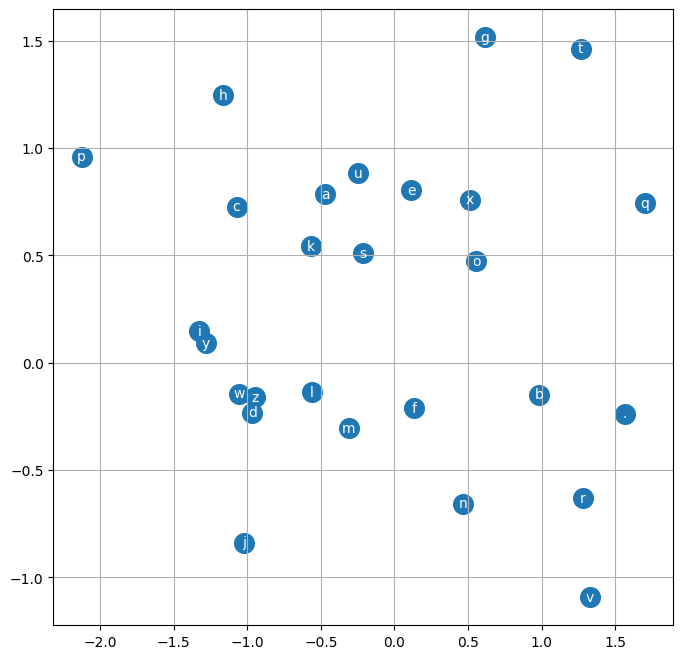

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [13]:
@torch.no_grad()
def predict(parameters, count=10):
    for i in range(count):
        out = []
        context = [0] * block_size
        [C, W1, b1, W2, b2] = parameters
        while True:
            emb = C[torch.tensor([context])]
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            p = F.softmax(logits, dim=1)

            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            context = context[1:] + [ix]
            if(ix == 0):
                break
            out.append(ix)
        print(''.join(itos[i] for i in out))

In [21]:
h = train(Xtr, Ytr, parameters, 64, iterations=1)[3]
hpreact = train(Xtr, Ytr, parameters, 64, iterations=1)[4]

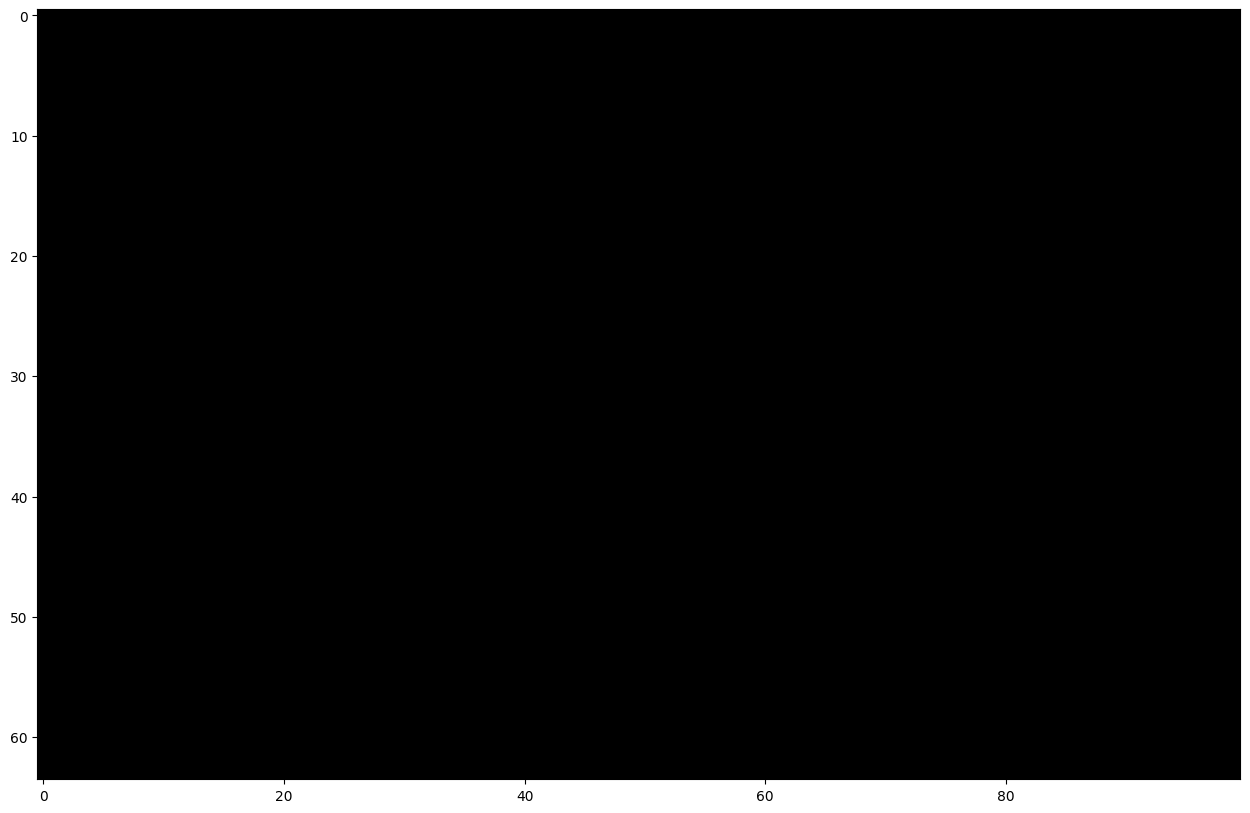

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([ 12.,  16.,  39.,  43., 103.,  70.,  83., 104., 141., 129., 153.,
        133., 160., 138., 145., 200., 190., 159., 203., 164., 195., 202.,
        170., 188., 154., 208., 212., 162., 201., 172., 127., 170., 144.,
        144., 141., 118., 166., 216., 139., 124., 141., 108., 123.,  84.,
         68.,  35.,  48.,  29.,  14.,  12.]),
 array([-0.9814254 , -0.94238835, -0.90335129, -0.86431424, -0.82527719,
        -0.78624013, -0.74720308, -0.70816602, -0.66912897, -0.63009191,
        -0.59105486, -0.5520178 , -0.51298075, -0.47394369, -0.43490664,
        -0.39586958, -0.35683253, -0.31779547, -0.27875842, -0.23972136,
        -0.20068431, -0.16164725, -0.1226102 , -0.08357314, -0.04453609,
        -0.00549904,  0.03353802,  0.07257507,  0.11161213,  0.15064918,
         0.18968624,  0.22872329,  0.26776035,  0.3067974 ,  0.34583446,
         0.38487151,  0.42390857,  0.46294562,  0.50198268,  0.54101973,
         0.58005679,  0.61909384,  0.6581309 ,  0.69716795,  0.73620501,
 

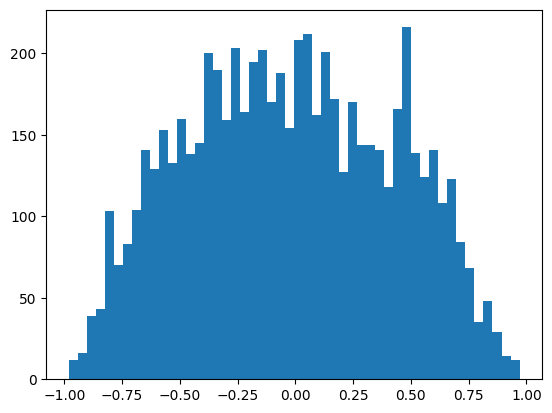

In [23]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   1.,   0.,   2.,   4.,   5.,  10.,  14.,  29.,  22.,  29.,
         64.,  72.,  98., 109., 149., 160., 230., 242., 262., 295., 306.,
        356., 385., 399., 394., 377., 352., 332., 254., 241., 288., 202.,
        170., 137., 115.,  81.,  62.,  38.,  35.,  18.,  16.,  18.,   7.,
          4.,   6.,   3.,   3.,   2.,   1.]),
 array([-2.10089207, -2.01814526, -1.93539845, -1.85265163, -1.76990482,
        -1.68715801, -1.6044112 , -1.52166439, -1.43891758, -1.35617077,
        -1.27342396, -1.19067715, -1.10793034, -1.02518353, -0.94243671,
        -0.8596899 , -0.77694309, -0.69419628, -0.61144947, -0.52870266,
        -0.44595585, -0.36320904, -0.28046223, -0.19771542, -0.11496861,
        -0.03222179,  0.05052502,  0.13327183,  0.21601864,  0.29876545,
         0.38151226,  0.46425907,  0.54700588,  0.62975269,  0.7124995 ,
         0.79524632,  0.87799313,  0.96073994,  1.04348675,  1.12623356,
         1.20898037,  1.29172718,  1.37447399,  1.4572208 ,  1.53996761,
 

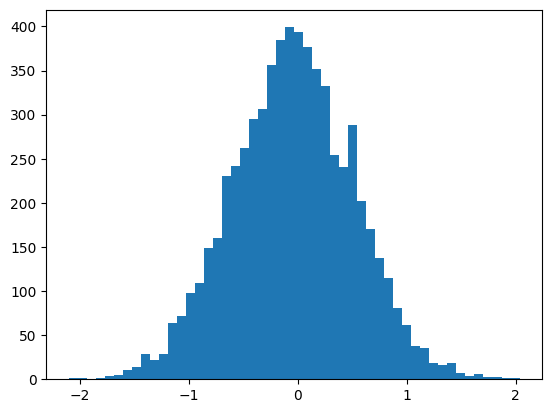

In [24]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [25]:
[params, si, li] = train(Xtr, Ytr, parameters, 64)

KeyboardInterrupt: 

In [ ]:
benchmark(Xtr, Ytr, parameters)
benchmark(Xdev, Ydev, parameters)

tensor(2.1015, grad_fn=<NllLossBackward0>)
tensor(2.1510, grad_fn=<NllLossBackward0>)


tensor(2.1510, grad_fn=<NllLossBackward0>)

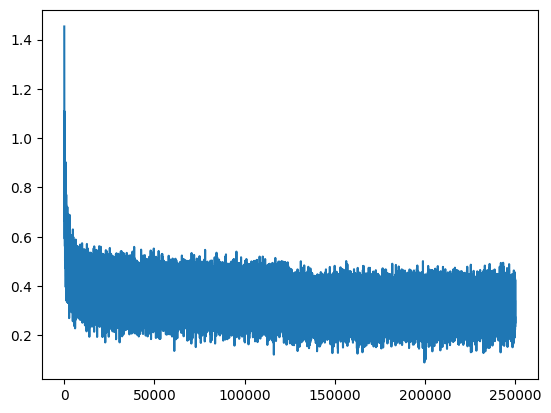

In [ ]:
stats_plot(si, li)

In [165]:
predict(parameters, 10)

sir
giely
kit
abyonny
eluna
szaymerion
nivanne
malaser
leigh
dussa


In [22]:
from typing import Any
from torch import Tensor


class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x) -> float:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self) -> int:
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.dim = dim
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: Tensor) -> Tensor:
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x) -> Any:
        self.out = torch.tanh(x);
        return self.out
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear( n_embd * block_size, n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [33]:
max_steps = 200000
batch_size = 32
lossi = []
lri = []
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
ud = []
# [C, W1, b1, W2, b2] = parameters
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (batch_size,))
  Xb, Yb = X[ix], Y[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  # hpreact = embcat @ W1 + b1
  # h = torch.tanh(hpreact)
  # logits = h @ W2 + b2
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update weights
  # lr = lrs[i]
  lr = 0.1 if i < max_steps / 2 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  # stepi.append(i)
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
  if i > 1000: # debug
    break # debug
  # break # debug

Text(0.5, 1.0, 'Activation distributions')

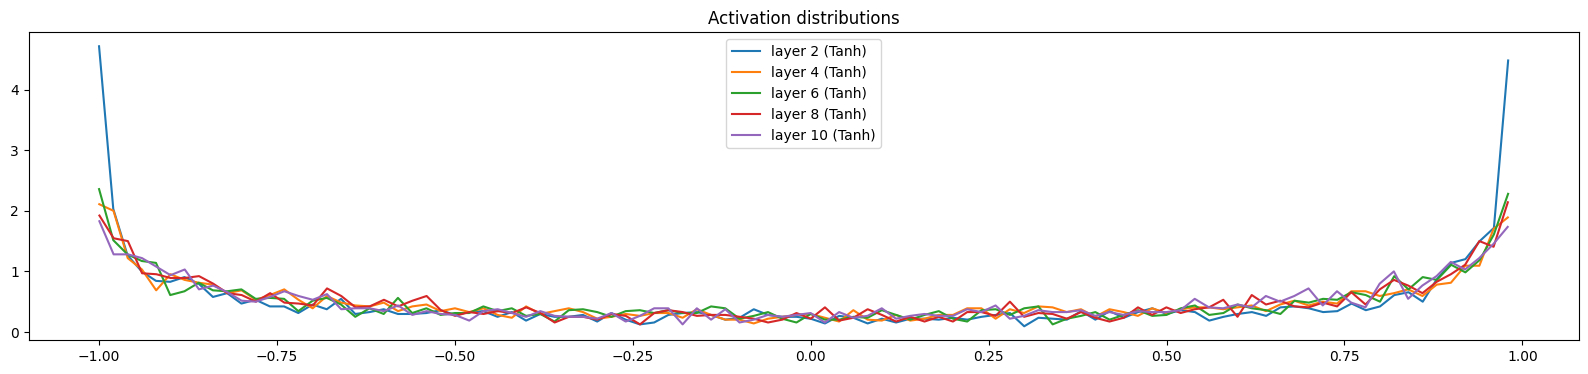

In [34]:
# histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i+1} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distributions')

Text(0.5, 1.0, 'weight gradient distributions')

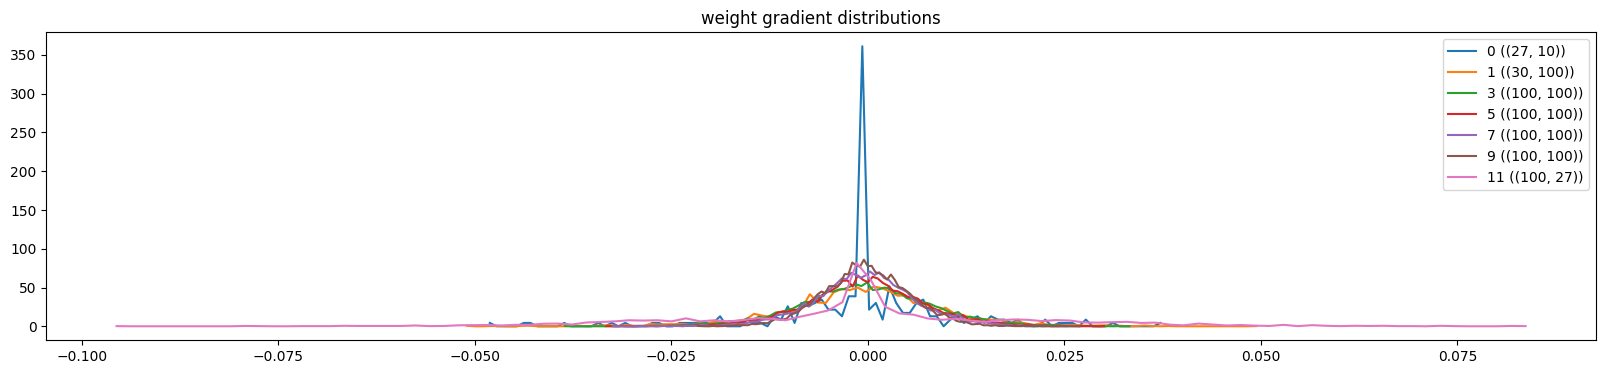

In [35]:
# histograms
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends)
plt.title('weight gradient distributions')

Text(0.5, 1.0, 'data/param ratio')

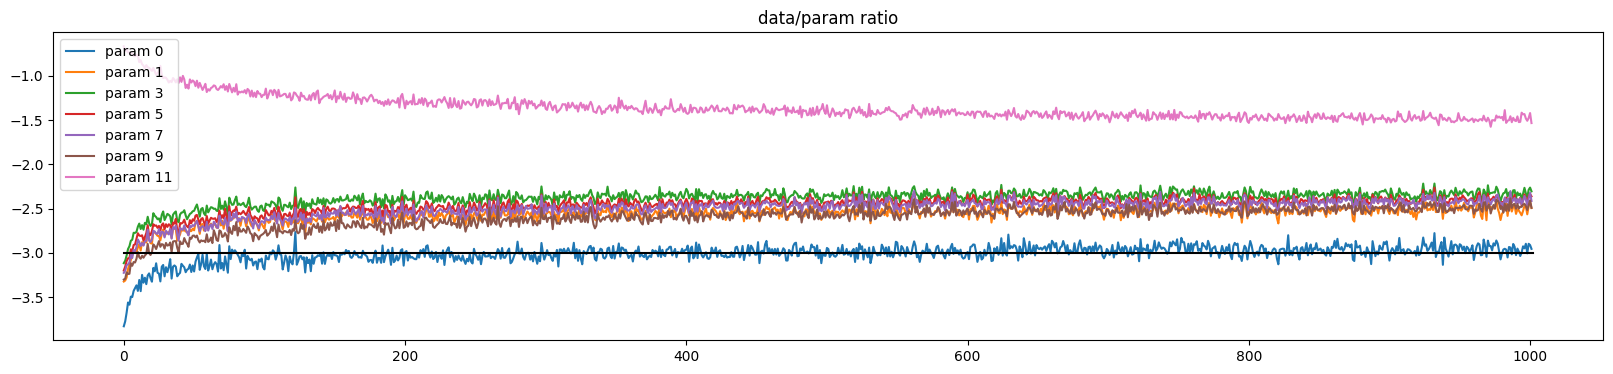

In [37]:
# histograms
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends)
plt.title('data/param ratio')